In [1]:
import pandas as pd
import dask.dataframe as dd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns

In [2]:
FF_UNI_dir = "/home/evos/Outputs/CRC/UNI_features_TCGA/FF"
FF_UNI_dd = dd.read_parquet(f"{FF_UNI_dir}/FF_features_batch_*.parquet")
#FF_UNI = FF_UNI_dd.compute()
FFPE_UNI_dir = "/home/evos/Outputs/CRC/UNI_features_TCGA/FFPE"
FFPE_UNI_dd = dd.read_parquet(f"{FFPE_UNI_dir}/FF_features_batch_*.parquet")
#FFPE_UNI = FFPE_UNI_dd.compute()
orion_UNI_dir = "/home/evos/Outputs/CRC/Orion/UNI_features_orion/no_preproc"
orion_UNI_dd = dd.read_parquet(f"{orion_UNI_dir}/features_batch_*.parquet")
#orion_UNI = orion_UNI_dd.compute()
orion_UNI_gamma_dir = "/home/evos/Outputs/CRC/Orion/UNI_features_orion/gamma"
orion_UNI_gamma_dd = dd.read_parquet(f"{orion_UNI_gamma_dir}/features_batch_*.parquet")

orion_UNI_macenko_dir = "/home/evos/Outputs/CRC/Orion/UNI_features_orion/macenko"
orion_UNI_macenko_dd = dd.read_parquet(f"{orion_UNI_macenko_dir}/features_batch_*.parquet")


In [3]:
#orion_UNI = orion_UNI.rename(columns={'section': 'Section'})
metadata_columns = ['tile_ID', 'sample_submitter_id', 'slide_submitter_id', 'Section', 'Coord_X', 'Coord_Y']  # Replace with actual metadata column names

FF_UNI_features = FF_UNI_dd.drop(columns=metadata_columns)
FFPE_UNI_features = FFPE_UNI_dd.drop(columns=metadata_columns)
orion_UNI_features = orion_UNI_dd.drop(columns=metadata_columns)
orion_UNI_gamma_features = orion_UNI_gamma_dd.drop(columns=metadata_columns)
orion_UNI_macenko_features = orion_UNI_macenko_dd.drop(columns=metadata_columns)

FF_rows = FF_UNI_dd.shape[0].compute()
FFPE_rows = FFPE_UNI_dd.shape[0].compute() 
orion_rows = orion_UNI_dd.shape[0].compute()
orion_gamma_rows = orion_UNI_gamma_dd.shape[0].compute()
orion_macenko_rows = orion_UNI_macenko_dd.shape[0].compute()

In [4]:
# Define a target size for subsampling (adjust based on memory limits)
target_size = 100000  # Total rows after subsampling (adjust as needed)

# Calculate subsample sizes proportionally
total_rows = FF_rows + orion_rows + orion_gamma_rows + FFPE_rows

FF_sample_size = int((FF_rows / total_rows) * target_size)
orion_sample_size = int((orion_rows / total_rows) * target_size)
orion_gamma_sample_size = int((orion_gamma_rows / total_rows) * target_size)
orion_macenko_sample_size = int((orion_macenko_rows / total_rows) * target_size)
FFPE_sample_size = int((FFPE_rows / total_rows) * target_size)

# Subsample each dataset
FF_sample_dd = FF_UNI_features.sample(frac=(FF_sample_size / FF_rows), random_state=42)
FF_sample = FF_sample_dd.compute()
FFPE_sample_dd = FFPE_UNI_features.sample(frac=(FFPE_sample_size / FFPE_rows), random_state=42)
FFPE_sample = FFPE_sample_dd.compute()
orion_sample_dd = orion_UNI_features.sample(frac=(orion_sample_size / orion_rows), random_state=42)
orion_sample = orion_sample_dd.compute()
orion_gamma_sample_dd = orion_UNI_gamma_features.sample(frac=(orion_gamma_sample_size / orion_gamma_rows), random_state=42)
orion_gamma_sample = orion_gamma_sample_dd.compute()
orion_macenko_sample_dd = orion_UNI_macenko_features.sample(frac=(orion_macenko_sample_size / orion_macenko_rows), random_state=42)
orion_macenko_sample = orion_macenko_sample_dd.compute()

# Combine the subsamples
combined_sample = np.vstack([FF_sample.values, orion_sample.values, orion_gamma_sample.values, orion_macenko_sample.values, FFPE_sample.values])

# Create labels
labels_sample = (['FF'] * len(FF_sample) +
                 ['Orion'] * len(orion_sample) +
                 ['Orion_Gamma'] * len(orion_gamma_sample) +
                 ['Orion_Macenko'] * len(orion_macenko_sample) +
                 ['FFPE'] * len(FFPE_sample))

pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_results = pca.fit_transform(combined_sample)


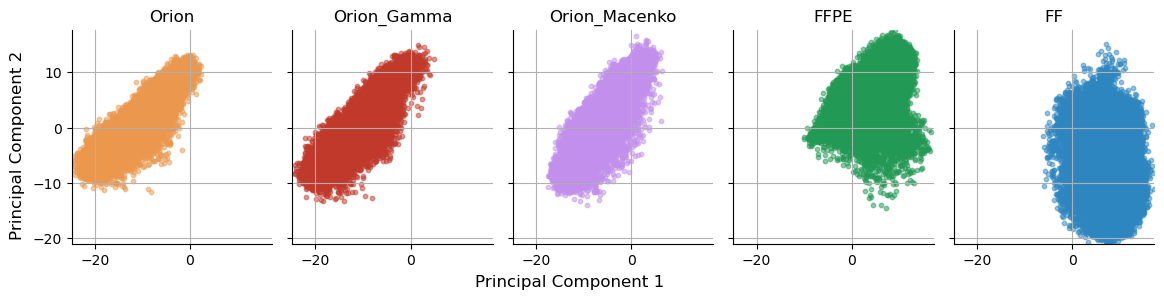

In [7]:
import matplotlib.pyplot as plt
import numpy as np

output_dir_plot = "/home/evos/figures/figures_preproc_scale_features"

# Define color map and dataset labels
color_map = {
    'FF': '#2e86c1',
    'FFPE': '#229954',
    'Orion': '#eb984e',
    'Orion_Gamma': '#c0392b',
    'Orion_Macenko': '#c290ec'
}
dataset_labels = ['Orion', 'Orion_Gamma', 'Orion_Macenko', 'FFPE', 'FF']

# Determine the x and y limits across all datasets
x_min, x_max = np.min(pca_results[:, 0]), np.max(pca_results[:, 0])
y_min, y_max = np.min(pca_results[:, 1]), np.max(pca_results[:, 1])

# Create subplots in a single row
fig, axes = plt.subplots(1, len(dataset_labels), figsize=(12, 3), sharex=True, sharey=True)

# Plot each dataset in its own subplot
for ax, label in zip(axes, dataset_labels):
    idx = [i for i, lbl in enumerate(labels_sample) if lbl == label]
    ax.scatter(pca_results[idx, 0], pca_results[idx, 1],
               label=label, alpha=0.5, s=10, color=color_map[label])
    ax.set_title(label)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid()
    #ax.legend()
    
    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add common x and y labels
fig.text(0.5, 0.04, "Principal Component 1", ha="center", va="center", fontsize=12)
fig.text(0.04, 0.5, "Principal Component 2", ha="center", va="center", rotation="vertical", fontsize=12)

# Show the plot
plt.tight_layout(rect=[0.04, 0.04, 1, 1])
plt.savefig(f"{output_dir_plot}/scale_features_UNI.png", dpi=300) 
plt.show()
plt.close()  

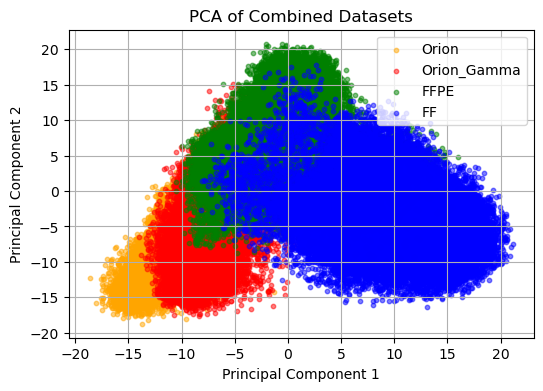

In [8]:
# Define consistent colors for each dataset
color_map = {
    'FF': 'blue',
    'FFPE': 'green',
    'Orion': 'orange',
    'Orion_Gamma': 'red'
}

# Define dataset labels and ensure 'FF' is plotted last
dataset_labels = ['Orion', 'Orion_Gamma', 'FFPE', 'FF']  # Adjust plotting order here

plt.figure(figsize=(6, 4))
for label in dataset_labels:
    idx = [i for i, lbl in enumerate(labels_sample) if lbl == label]
    plt.scatter(pca_results[idx, 0], pca_results[idx, 1],
                label=label, alpha=0.5, s=10, color=color_map[label])

plt.title("PCA of Combined Datasets")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()
